In [1]:
from scipy import stats
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.anova import anova_lm

plt.style.use("seaborn-v0_8")

# 参数检验

## 1. 正态性检验

### 1.1. 经验分布函数

设$x_1, x_2, ⋯ x_n$为总体$X$的一个样本，令$f(x)$为其中不大于$x$的随机变量的个数，定义经验分布函数为

$$
F_n (x) = \frac{1}{n}f(x), x ∈ ℝ
$$

一般地，先将样本值$x_1, x_2, ⋯ x_n$进行升序排列，并重新编号，则经验分布函数的观测值为

$$
F_n(x) =
\begin{cases}
  0, & x<x_{(1)} \\
  \frac{k}{n}, & x_{k} <x<x_{(k+ 1)} \\
  1, & x >x_{(n)}
\end{cases}
$$

> 1933 年，Glivenko（Валери Іванович Глущенко, 1897-1940）证明，当$n → +∞$，$F_n(x) = F(x)$。


### 1.2. 概率图

存在许多图形方法，用于通过将它们的分位数或密切相关的参数相互比较来比较两个概率分布：

- QQ-Plots：给定数据集的分位数相对于参考分布的分位数绘制，通常是标准。
- PP-Plots：根据参考分布的 CDF 绘制给定数据集的 CDF。
- 概率图：绘制给定数据集的有序值与参考分布的分位数。


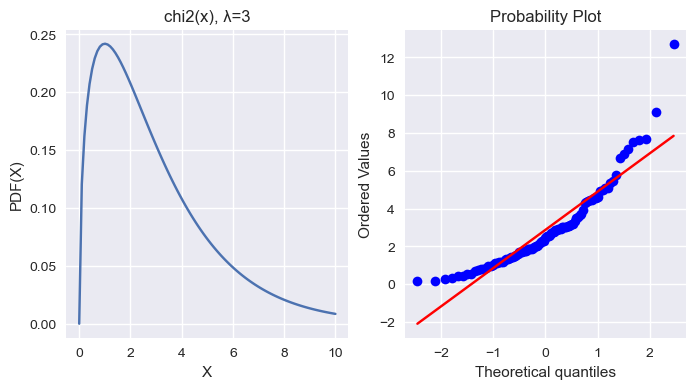

In [2]:
np.random.seed(42)
n_size = 100
x = np.linspace(0, 10, n_size)

λ = 3
chi2 = stats.chi2(λ)
y = chi2.pdf(x)

_, axes = plt.subplots(1, 2, figsize=(8, 4))

axes[0].plot(x, y)
axes[0].set(xlabel="X", ylabel="PDF(X)", title="chi2(x), λ=3")

data = chi2.rvs(n_size)
_ = stats.probplot(data, plot=axes[1])

plt.show()

### 1.3. Shapiro-Wilk W 检验

Shapiro-Wilk W 检验取决于观察的顺序统计量之间的协方差矩阵，适用于小样本场合$(n ≤ 50)$。是最常用的快速正态性检验方法。

- H₀: 样本服从高斯分布


### 1.4. KS 检验系

#### 1.4.1. KS 检验

Kolmogorov-Smirnov 检验通过比较容量为$n$的经验分布函数$F_n(x)$与给定分布函数$F₀(x)$的间隔，构造统计量$D$为两个分布函数的间隔最大值，来推断该样本是否来自给定分布函数的总体。适用于连续分布的独立样本。


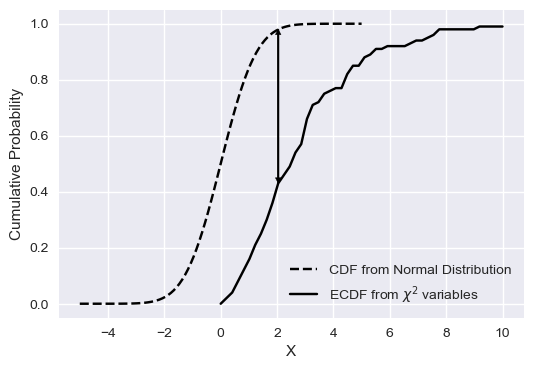

In [3]:
start, end = -5, 5
n_size = 100
x = np.linspace(start, end, n_size)
func = stats.norm()
y = func.cdf(x)

x_ecdf = np.linspace(start + 5, end + 5, n_size // 2)
np.random.seed(42)
_lambda = 3
chi2 = stats.chi2(_lambda)
data = chi2.rvs(n_size)
y_ecdf = sm.distributions.ECDF(data)(x_ecdf)

_, ax = plt.subplots(figsize=(6, 4))

ax.plot(x, y, "k--", label="CDF from Normal Distribution")
ax.plot(x_ecdf, y_ecdf, "k-", label="ECDF from $\chi^2$ variables")
ax.set(xlabel="X", ylabel="Cumulative Probability")

start_ind = np.min(np.where(x_ecdf >= 2))
arrow_start = np.array([x_ecdf[start_ind], y_ecdf[start_ind]])

start_ind2 = np.min(np.where(x >= 2))
arrow_end = np.array([x[start_ind2], y[start_ind2]])
arrow_len = arrow_end - arrow_start

arrow = dict(
    width=0.05, length_includes_head=True, head_length=0.02, head_width=0.2, color="k"
)

ax.arrow(arrow_start[0], arrow_start[1], 0, arrow_len[1], **arrow)
ax.arrow(arrow_start[0], arrow_start[1] + arrow_len[1], 0, -arrow_len[1], **arrow)
ax.legend()

plt.show()

#### 1.4.2. Lilliefors 检验

KS 检验的改进，用于一般的正态性检验，通过量化样本的经验分布函数（ECDF）与参考分布的累积分布函数（CDF）之间的距离，或两个样本的经验分布函数之间的距离，即用样本均值和标准差代替总体的期望和标准差，然后再用 K-S 正态性检验法，步骤相同。

> KS 检验只能检验是否一个样本来自于一个已知样本，而 Lilliefors 检验可检验是否来自未知总体。


#### 1.4.3. AD 检验

与 K-S 检验相比，Anderson-Darling 检验度量经验累积概率和理论累积概率之差的方法显得更加自然。同 KS 检验一样，可进行对多种分布相似性的检验。可以检验的分布包括 `['norm', 'expon', 'logistic', 'gumbel', 'gumbel_l', 'gumbel_r', 'extreme1']`。

$$
z=n∫_{-∞}^{∞} \bigg[F_n(x) -F(x)\bigg]^2 w(x)f(x) dx
$$

$$
A^2 = -n - ∑\frac{2i - 1}{n} \bigg[\ln F(Y_{i}) + \ln(1 -F(Y_{n + 1 -i}))\bigg]
$$

其中，$Y_{i} = \dfrac{X_{i} - \hat{μ}}{σ̂}$


## 2. 显著性检验

### 2.1. 单样本

- $σ^2$已知（_Z_ 检验）

$$
Z = \frac{X̂ - μ}{σ/\sqrt{n}}
$$

> 分母为分布跨度，跨度越小则统计量越大，越有可能拒绝 H₀。

$μ$的$1 - α$置信区间

$$
P\{|z| < z_{α/2} \} ⇒ (X̄ ± z_{α/2} \frac{σ}{\sqrt{n}})
$$

- $σ^2$ 未知（_t_ 检验）

由 _Z_ 统计量、$χ^2$分布和 _t_ 分布定义

$$
\frac{X̄ - μ}{σ/\sqrt n} /\sqrt{\dfrac{(n - 1)S^2}{σ^2}/{(n - 1)}}∼ \dfrac{N(0, 1)}{\sqrt{χ^2(n - 1)/(n - 1)}}
$$

化简左边的式子，可得

$$
\frac{X̄ - μ}{S/\sqrt n} ∼ t(n - 1)
$$

$μ$的$1 -α$置信区间

$$
P\{|t| < t_{α/2, n - 1} ⇒ (X̄ ± t_{α/2, n - 1} \dfrac{S}{\sqrt{n}})
$$

> 当$σ$未知，可用极差 × 0.25 近似


### 2.2. 配对双样本

在两组相互比较中，必须区分两个案例。将在不同时间从同一受试者记录的两个值相互比较。例如，学生进入小学和第一年后的身高，以检查他们是否已经成长（每个小学生身高相互独立）。由于我们只对第一次和第二次测量中每个受试者的差异感兴趣，因此该检验称为配对$t$检验，相当于均值差异的单样本$t$检验。

由上，设身高变化由同一因素引起，即认为身高差来自同一分布$N(μ_D, σ_D)$，则

$$
t = \frac{D̄}{S_d/\sqrt{n}}
$$

其中，$D̄$为样本差均值，$S_d$为样本差的样本方差


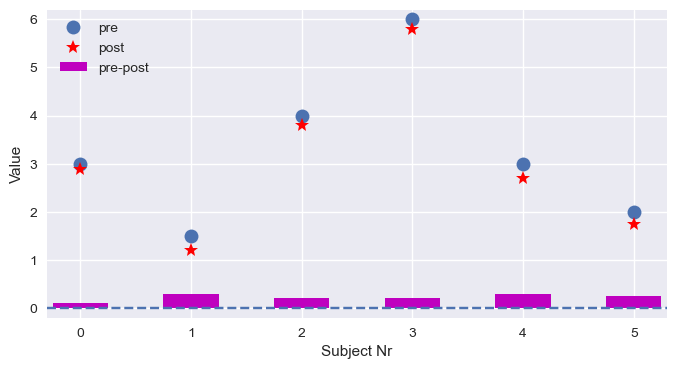

In [4]:
x = np.r_[3, 1.5, 4, 6, 3, 2]
dx = np.r_[0.1, 0.3, 0.2, 0.2, 0.3, 0.25]
xs = x - dx
index = range(len(x))

_, ax = plt.subplots(figsize=(8, 4))

ax.plot(x, "o", ms=10, label="pre")
ax.plot(xs, "r*", ms=10, label="post")
ax.bar(index, dx, width=0.5, align="center", color="m", label="pre-post")

ax.axhline(0, ls="--")
ax.set(xlim=(-0.3, 5.3), ylim=(-0.2, 6.2), xlabel="Subject Nr", ylabel="Value")
ax.legend(loc="upper left")

plt.show()

### 2.3. 独立双样本

- $σ_1, σ_2$已知

构造 _Z_ 统计量

$$
Z = \frac{X̄_1 - X̄_2}{\sqrt{\dfrac{σ_1^2}{n_1} + \dfrac{σ_2^2}{n_2}}} ∼ N(0, 1)
$$

$μ_1 - μ_2$的$1 -α$置信区间

$$
(X̄_1 - X̄_2 ± z_{α/2}*\sqrt{\dfrac{σ_1^2}{n_1} + \dfrac{σ_2^2}{n_2}})
$$

- $σ_1, σ_2$未知，但相等

由于往往不能确定方差是否相等，故需要先进行方差齐性检验，即 _F_ 检验。

由

$$
X̄_1 - X̄_2 ∼ N(μ_1 - μ_2, \frac{σ^2}{n1} + \frac{σ}{n_2})
$$

构造 _t_ 统计量

$$
\frac{X̄_1 - X̄_2}{S_w\sqrt{\frac{1}{n_1} + \frac{1}{n_2}}} ∼ t(n_1 + n_2 - 2)
$$

其中，$S_w = \sqrt{\dfrac{(n_1 - 1)S_1^2 + (n_2-1)S_2^2}{n_1 + n_2 - 2}}$ 为合并标准差（pooled standard deviation）。

$μ_1 - μ_2$的$1 - α$置信区间

$$
(X̄_1 - X̄_2 ± t_{α/2, n_1 + n_2 - 2}*S_w \sqrt{\dfrac{1}{n_1} + \dfrac{1}{n_2}})
$$

- $σ_1, σ_2$未知，但不等

$$
t = \dfrac{X̄_1 - X̄_2}{\sqrt{\frac{S_1^2}{n_1} + \frac{S_2^2}{n_2}}}
$$

使用 Satterthwaite 近似，使用自由度为下式的 _t_ 分布

$$
df = \frac{(\frac{S_1^2}{n_1} + \frac{S_2^2}{n_2})^2}{\frac{(\frac{S_1^2}{n_1})^2}{n_1 - 1} + \frac{(\frac{S_2^2}{n_2})^2}{n_2-1}}
$$


## 3. 相关性检验

也叫方差相等检验。用于检验两组样本是否独立。

### 3.1. 单样本

$χ^2$检验用途非常广，它在分类资料统计推断中的应用，包括：两个率或两个构成比比较的检验；多个构成比比较的检验以及分类资料的相关分析等。

> 在大数据运营场景中，通常用在某个变量（或特征）值是不是和因变量有显著关系。

由定义

$$
χ^2 = \dfrac{(n - 1)S^2}{σ^2} = \dfrac{∑(X_{i}X̄)^2}{σ^2}∼ χ^2(n - 1)
$$

$σ^2$的$1 - α$置信区间

$$
P\{χ^2_{1 - α/2, n - 1} < χ^2 < χ^2_{α/2, n - 1\}} ⇒ (\dfrac{(n - 1)S^2}{χ^2_{α/2, n - 1}}, \dfrac{(n - 1)S^2}{χ^2_{1 - α/2, n - 1}})
$$


### 3.2. 双样本

H₀: 样本间是相互独立的。

构造 _F_ 统计量

$$
\frac{S_1^2/S_2^2}{σ_1/σ_2^2} ∼ F(n_1 - 1, n_2-1)
$$

$σ_1^2/σ_2^2$的$1 - α$置信区间

$$
P\{F^2_{1 - α/2, n_1 - 1, n_2 - 2} < F < F^2_{α/2, n_1 - 1, n_2 - 2}\} ⇒ (\dfrac{S_1^2/S_2^2}{F^2_{α/2, n_1 - 1, n_2 - 2}}, \dfrac{S_1^2/S_2^2}{F^2_{1 - α/2, n_1 - 1, n_2 - 2}})
$$


### 3.3. 多样本

- Bartlett 检验：用于正态数据的方差齐次检验
- Levene 检验：用于非正态数据的方差齐次检验。其既可用于检验两总体方差齐性，也可用于检验多个总体的方差齐性。
- Fligner-Killeen 检验：用于同分布数据的方差齐次检验，与分布无关


## 4. 单因素方差分析

### 4.1. 基本思想

方差分析（Analysis of Variance，ANOVA）由英国统计与遗传学家 Ronald A. Fisher（1890 ～ 1962）发明，用于两个及两个以上**样本**均数差的显著性检验。

ANOVA 的思想是将方差分解为组内方差和组间方差，并观察这些分布是否与整个样本来自同一分布的零假设相匹配。区分不同分组的变量通常称为因子（factor）或处理（treatment）。对一个因子进行的分析，称为单因素方差分析（one-way ANOVA）。

> 注意，使用 ANOVA，在每个分析组中拥有完全相同数量的样本非常重要，同时要保证**总体方差相等**。

![anova](images/ch04/anova.png)

设样本有$k$个分组，受到同一因素 _A_ 影响，因素 _A_ 有$n_{j}$个水平，样本个数$n = k⋅n_{j}$，可得样本方差（也叫均方）

$$
std^2 = \frac{1}{df_T} ∑(X_{ij} - X̂)^2 \frac{\mathrm{SS_T}}{df_T}
$$

其中，$SS_T$为总偏差平方和，$df_T$为总自由度。

$$
\mathrm{SS_T} = \mathrm{SS_A} + \mathrm{SS_E}
$$

$$
df_T = df_A + df_E
$$

- H₀: $E(\mathrm{MS_A}) = σ^2$
- 拒绝条件：$F > F_{α}$

|    方差来源    |     平方和      | 自由度  |              均方              |                  F 值                  |
| :------------: | :-------------: | :-----: | :----------------------------: | :------------------------------------: |
| 因素 A（组间） | $\mathrm{SS_A}$ | $k - 1$ |  $\dfrac{\mathrm{SS_A}}{k-1}$  | $\dfrac{\mathrm{MS_A}}{\mathrm{MS_E}}$ |
|  误差（组内）  | $\mathrm{SS_E}$ | $n - k$ | $\dfrac{\mathrm{SS_E}}{n - k}$ |                                        |
|      总和      | $\mathrm{SS_T}$ | $n - 1$ |                                |                                        |

> $F$值即为组间方差与组内方差的比值。组间的差异越大，$F$值越大，越可能拒绝 H₀。


In [5]:
df = pd.read_csv("data/altman_910.txt", sep=",", names=["value", "treatment"])

df.head()

,value,treatment
0,243,1
1,251,1
2,275,1
3,291,1
4,347,1


In [6]:
model = smf.ols("value~C(treatment)", df).fit()
res = anova_lm(model)

print(res)

                df        sum_sq      mean_sq         F    PR(>F)
C(treatment)   2.0  15515.766414  7757.883207  3.711336  0.043589
Residual      19.0  39716.097222  2090.320906       NaN       NaN


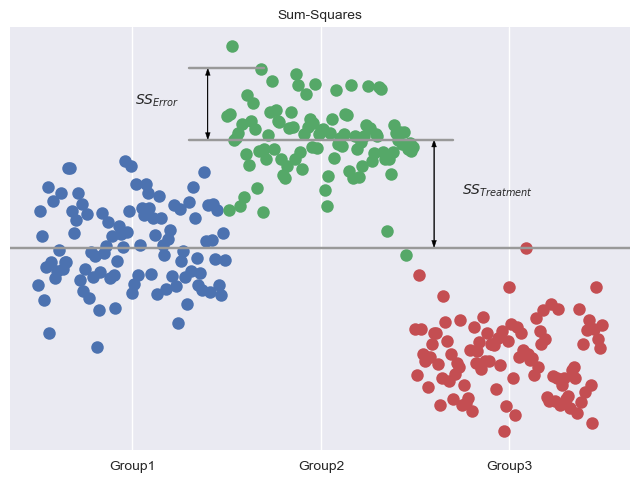

In [7]:
_, ax = plt.subplots(1, 1)

np.random.seed(123)
loc, scale = [5, 5.3, 4.7], 0.1
n_size = 100

mean_list = []

for i in range(3):
    data = stats.norm(loc[i], scale).rvs(n_size)
    offset = i * n_size
    ax.plot(offset + np.arange(n_size), data, ".", ms=18)
    mean_list.append(np.mean(data))

ax.xaxis.set_ticks([50, 150, 250])
ax.set_xticklabels(["Group1", "Group2", "Group3"])
ax.yaxis.set_ticks([])
ax.set_title("Sum-Squares", fontsize="medium")

mean_mean = np.mean(mean_list)
ax.axhline(mean_mean, color="#999999")
ax.plot([80, 220], [mean_list[1], mean_list[1]], "#999999")
ax.plot([80, 120], [mean_list[1] + 0.2, mean_list[1] + 0.2], "#999999")

arrow = dict(
    width=0.05, length_includes_head=True, head_length=0.02, head_width=2.5, color="k"
)

d_mean = mean_list[1] - mean_mean

ax.arrow(90, mean_list[1], 0, 0.2, **arrow)
ax.arrow(90, mean_list[1] + 0.2, 0, -0.2, **arrow)
ax.arrow(210, mean_list[1] - d_mean, 0, d_mean, **arrow)
ax.arrow(210, mean_list[1], 0, -d_mean, **arrow)
ax.text(225, (mean_mean + mean_list[1]) / 2.0, "$SS_{Treatment}$", fontsize="medium")
ax.text(75, mean_list[1] + 0.1, "$SS_{Error}$", ha="right", fontsize="medium")

plt.show()

> 注意区别，样本与因素，双样本 ANOVA：$t^2_{val} = F_{val}$


In [8]:
galton = pd.read_csv("data/galton.csv")
galton.head()

,family,father,mother,sex,height,nkids
0,1,78.5,67.0,M,73.2,4
1,1,78.5,67.0,F,69.2,4
2,1,78.5,67.0,F,69.0,4
3,1,78.5,67.0,F,69.0,4
4,2,75.5,66.5,M,73.5,4


In [9]:
f_val, p_val = stats.f_oneway(galton["father"], galton["mother"])
t_val, p_val_t = stats.ttest_ind(galton["father"], galton["mother"])

print(f"from the t-test, t² = {t_val**2:5.3f}\nfrom the F-test, F = {f_val:5.3f}")

np.testing.assert_almost_equal(t_val**2, f_val)

from the t-test, t² = 2083.481
from the F-test, F = 2083.481


### 4.2. 平方和

- 处理平方和（处理值对总均值的偏差平方和）

$$
\mathrm{SS_A} = ∑_{j = 1}^{k} ∑_{i = 1}^{n_{j}}{(X̄_{⋅j} - X̂)}^2 = ∑_{j = 1}^{k} n_{j} {X̂_{⋅j}}^2
$$

- 误差平方和（观测值对处理值对偏差平方和）

$$
\mathrm{SS_E} = ∑_{j = 1}^{k} ∑_{i = 1}^{n_{j}}{(X_{ij} - {X̄_{⋅j}})}^2
$$


### 4.3. 多重比较

ANOVA 只能判断总体中的不同处理间是否有显著差异，但若想具体到各处理间的显著性差异有几种，还需进行多重比较。其中，Tukey 检验最常用，Bonferroni _t_ 检验法最严格，$LSD_α$法最宽松。

- Tukey 检验：有时也称为 Tukey 诚实显着性差异检验（HSD），用于控制多个比较中的$α$。它基于 _t_ 分布化的范围。

- Dunnett-t 检验：适用于$k-1$个实验组与对照组均数的比较。

- Bonferroni-t 校正法：Tukey 的 _t_ 范围检验（HSD）是特定于所有 _{k}_ 个独立样本对的比较的检验。但，我们可对所有对进行 _t_ 检验，计算 p 值并对多个检验问题应用其中一个 p 值校正。Bonferroni-t 校正法通过对每次检验的显著性水平进行调整，使总$α$控制在给定水平以下。

- Holm 校正法：也称 Holm-Bonferroni 方法，依次将最小 p 值与在每次检验中减少的$α$进行比较。例如，若有三组（三个比较），这意味着第一个 p 值在 0.05 / 3 水平（0.017）检验，第二个在 0.05 / 2 水平（0.025）检验，第三个在 0.05 / 1 水平（0.05）。


## 5. 双因素方差分析

### 5.1. 等重复双因素

设样本受两个因素影响，其中因素$𝑨$有$r$个水平，因素 B 有$s$个水平，每对$(A_{i}, B_{j})$有$t$个观测值。也叫等重复双因素方差分析。

$$
SS_T =SS_A + SS_B + SS_{AB} + SS_E
$$

H₀

- $H_{01}: E(MS_A) = σ^2$
- $H_{02}: E(MS_B) = σ^2$
- $H_{03}: E(MS_{AB}) = σ^2$

拒绝条件：$F > F_{α}$

| 方差来源 |  平方和   |      自由度      |               均方                |         F 值         |
| :------: | :-------: | :--------------: | :-------------------------------: | :------------------: |
|  因素 A  |  $SS_A$   |     $r - 1$      |       $\dfrac{SS_A}{r - 1}$       | $\dfrac{MS_A}{MS_E}$ |
|  因素 B  |  $SS_B$   |     $s - 1$      |       $\dfrac{SS_B}{s - 1}$       | $\dfrac{MS_B}{MS_E}$ |
| 交互作用 | $SS_{AB}$ | $(r - 1)(s - 1)$ | $\dfrac{SS_{AB}}{(r - 1)(s - 1)}$ |                      |
|   误差   |  $SS_E$   |   $rs(t - 1)$    |      $\dfrac{SS_E}{rs(t-1)}$      |                      |
|   总和   |  $SS_T$   |    $rst - 1$     |                                   |                      |


In [10]:
df = pd.read_csv("data/altman_126.txt", sep=",", names=["hs", "fetus", "observer"])

df.head()

,hs,fetus,observer
0,14.3,1,1
1,14.0,1,1
2,14.8,1,1
3,13.6,1,2
4,13.6,1,2


In [11]:
formula = "hs~C(fetus) + C(observer) + C(fetus):C(observer)"
lm = smf.ols(formula, df).fit()
res = anova_lm(lm)

print(res)

                        df      sum_sq     mean_sq            F        PR(>F)
C(fetus)               2.0  324.008889  162.004444  2113.101449  1.051039e-27
C(observer)            3.0    1.198611    0.399537     5.211353  6.497055e-03
C(fetus):C(observer)   6.0    0.562222    0.093704     1.222222  3.295509e-01
Residual              24.0    1.840000    0.076667          NaN           NaN


### 5.2. 平方和

- 处理平方和 1

$$
SS_A = st∑_{i = 1}^{r} (X_{i⋅⋅} - X̂)^2
$$

- 处理平方和 2

$$
SS_B = rt∑_{j = 1}^s(X_{⋅j⋅} - X̂)^2
$$

- 交互平方和

$$
SS_{AB} = t∑_{i = 1}^{r} ∑_{j = 1}^s (X_{ij⋅} - X_{i⋅⋅} - X_{⋅j⋅} - X̂)^2
$$

- 误差平方和

$$
S_E = ∑_{i = 1}^{r} ∑_{j = 1}^s ∑_{k = 1}^{t} (X_{ijk} - X_{ij⋅})^2
$$

- 期望

$$
E(S_A) = (r-1)σ^2 + st∑_{i = 1}^{r}α_{i}^2
$$

$$
E(S_B) = (s-1)σ^2 + rt∑_{i = 1}^{r} β_{j}^2
$$

$$
E(S_{AB}) = (r-1)(s-1)σ^2 + t∑_{i = 1}^{r} ∑_{j = 1}^{r} γ_{ij}^2
$$

$$
E(S_E) = rs(t-1)σ^2
$$


### 5.3. 嵌套双因素

设样本受因素$𝑨$影响，而因素$𝑨$又受因素$B$影响，两个因素分别有$p, q$个水平，每个因素$B$有$n$个观测值。

$$
S_T = S_B + S_E
$$

| 方差来源  |   平方和    |  自由度   |            均方            |           F 值            |
| :-------: | :---------: | :-------: | :------------------------: | :-----------------------: |
|  因素 A   |   $SS_A$    |  $p - 1$  |   $\dfrac{SS_A}{p - 1}$    | $\dfrac{MS_A}{MS_{B(A)}}$ |
| 因素 B(A) | $SS_{B(A)}$ |  $q - p$  | $\dfrac{SS_{B(A)}}{q - p}$ | $\dfrac{MS_{B(A)}}{MS_E}$ |
|   误差    |   $SS_E$    | $pqn - q$ |  $\dfrac{SS_E}{pqn - 1}$   |                           |
|   总和    |   $SS_T$    | $pqn - 1$ |                            |                           |


### 5.4. 平方和

- 处理平方和（因素 A 间）

$$
SS_A = ∑n_{i⋅} (X̄_{i⋅⋅} - X̂)^2
$$

- 处理平方和 2（因素 A 内因素 B 间）

$$
SS_{B(A)} = ∑∑n_{ij}(X̄_{ij⋅} - X̄_{i⋅⋅})^2
$$

- 误差平方和

$$
S_E = ∑∑∑(X̄_{ijk} - X̄_{ij⋅})^2
$$
